Import Libraries

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.metrics.pairwise import cosine_similarity
import pickle

Load Dataset

In [18]:
df = pd.read_csv("../data/Groceries_dataset.csv")
df.head()

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


Basic EDA

In [19]:
print("Shape:", df.shape)
print("\nMissing Values:\n", df.isnull().sum())
print("\nUnique Customers:", df["Member_number"].nunique())
print("Unique Products:", df["itemDescription"].nunique())

Shape: (38765, 3)

Missing Values:
 Member_number      0
Date               0
itemDescription    0
dtype: int64

Unique Customers: 3898
Unique Products: 167


Top Selling Products

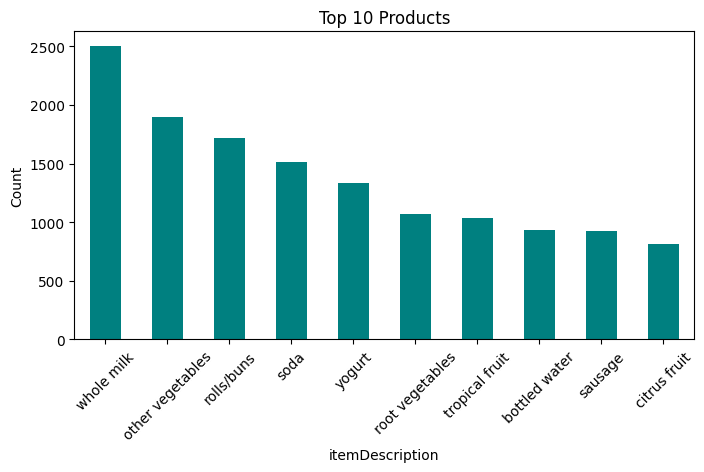

In [20]:
top_products = df["itemDescription"].value_counts().head(10)

plt.figure(figsize=(8,4))
top_products.plot(kind="bar", color="teal")
plt.title("Top 10 Products")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

Transactions per Customer

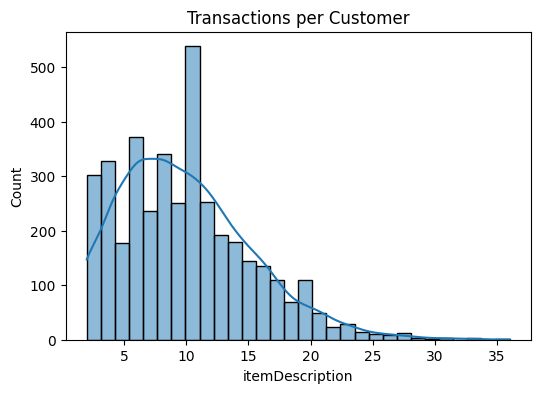

In [21]:
transactions_per_user = df.groupby("Member_number")["itemDescription"].count()

plt.figure(figsize=(6,4))
sns.histplot(transactions_per_user, bins=30, kde=True)
plt.title("Transactions per Customer")
plt.show()

Create Basket (One-Hot Encoding)

In [22]:
basket = (
    df.groupby(["Member_number", "itemDescription"])["itemDescription"]
      .count()
      .unstack()
      .fillna(0)
)

basket = basket.applymap(lambda x: 1 if x > 0 else 0)
basket.head()

C:\Users\admin\AppData\Local\Temp\ipykernel_4484\683367776.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)


itemDescription,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
Member_number,,,,,,,,,,,,,,,,,,,,,
1000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1001,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,1,0,1,0,0
1002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Apriori – Market Basket Analysis

In [23]:
frequent_itemsets = apriori(
    basket,
    min_support=0.02,
    use_colnames=True
)

frequent_itemsets.sort_values("support", ascending=False).head()

c:\Users\admin\AppData\Local\Programs\Python\Python314\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:175: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
85,0.458184,(whole milk)
52,0.376603,(other vegetables)
64,0.349666,(rolls/buns)
73,0.313494,(soda)
86,0.282966,(yogurt)


Association Rules

In [24]:
rules = association_rules(
    frequent_itemsets,
    metric="confidence",
    min_threshold=0.3
)

rules = rules.sort_values("confidence", ascending=False)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
806,"(bottled water, other vegetables, yogurt)",(whole milk),0.032324,0.458184,0.022063,0.682540,1.489664,1.0,0.007252,1.706721,0.339688,0.047097,0.414081,0.365346
308,"(shopping bags, bottled beer)",(whole milk),0.030272,0.458184,0.020010,0.661017,1.442690,1.0,0.006140,1.598358,0.316429,0.042716,0.374358,0.352345
837,"(rolls/buns, other vegetables, yogurt)",(whole milk),0.052335,0.458184,0.034377,0.656863,1.433623,1.0,0.010398,1.579008,0.319170,0.072198,0.366691,0.365945
415,"(canned beer, shopping bags)",(whole milk),0.033607,0.458184,0.022063,0.656489,1.432806,1.0,0.006664,1.577287,0.312574,0.046969,0.366000,0.352320
850,"(other vegetables, soda, yogurt)",(whole milk),0.043099,0.458184,0.027963,0.648810,1.416047,1.0,0.008216,1.542799,0.307042,0.059079,0.351827,0.354920


Save Apriori Rules

In [25]:
with open("../models/apriori_rules.pkl", "wb") as f:
    pickle.dump(rules, f)

print("Apriori rules saved")

Apriori rules saved


Collaborative Filtering (Item-Similarity)

In [26]:
item_user_matrix = basket.T
item_user_matrix.head()

Member_number,1000,1001,1002,1003,1004,1005,1006,1008,1009,1010,...,4991,4992,4993,4994,4995,4996,4997,4998,4999,5000
itemDescription,,,,,,,,,,,,,,,,,,,,,
Instant food products,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
UHT-milk,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
abrasive cleaner,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
artif. sweetener,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
baby cosmetics,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Cosine Similarity Matrix

In [27]:
similarity_matrix = cosine_similarity(item_user_matrix)

similarity_df = pd.DataFrame(
    similarity_matrix,
    index=item_user_matrix.index,
    columns=item_user_matrix.index
)

similarity_df.head()

itemDescription,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
itemDescription,,,,,,,,,,,,,,,,,,,,,
Instant food products,1.00000,0.029520,0.000000,0.000000,0.000000,0.000000,0.011736,0.0,0.053824,0.021962,...,0.043853,0.036515,0.039357,0.042059,0.0,0.055523,0.029531,0.094699,0.066082,0.033333
UHT-milk,0.02952,1.000000,0.036564,0.031846,0.000000,0.028583,0.062363,0.0,0.108575,0.094006,...,0.032364,0.008085,0.087137,0.125711,0.0,0.076832,0.074101,0.213725,0.156636,0.066421
abrasive cleaner,0.00000,0.036564,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.039505,0.024179,...,0.024140,0.000000,0.012999,0.034729,0.0,0.034385,0.016256,0.045404,0.057775,0.000000
artif. sweetener,0.00000,0.031846,0.000000,1.000000,0.107211,0.000000,0.000000,0.0,0.025807,0.042119,...,0.063078,0.000000,0.022644,0.030248,0.0,0.019966,0.000000,0.079092,0.022365,0.000000
baby cosmetics,0.00000,0.000000,0.000000,0.107211,1.000000,0.000000,0.000000,0.0,0.026745,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.017384,0.000000


Save Similarity Model

In [28]:
with open("../models/item_similarity.pkl", "wb") as f:
    pickle.dump(similarity_df, f)

print("Item similarity model saved")

Item similarity model saved


Test Recommendations

In [30]:
def recommend_cf(product, top_n=5):
    if product not in similarity_df.columns:
        return []
    return similarity_df[product].sort_values(ascending=False)[1:top_n+1]

recommend_cf("whole milk")

itemDescription
other vegetables    0.460718
rolls/buns          0.446088
yogurt              0.418225
soda                0.398693
bottled water       0.359096
Name: whole milk, dtype: float64